In [1]:
# Needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime,timedelta
from scipy import io,signal,stats
import time

import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
def load_data(fobs,fpred):
    # load matfiles
    obs = io.loadmat(fobs)
    pred = io.loadmat(fpred)
    
    # Estimate u,v for pred
    pred['u'] = pred['wndspd']*np.cos((90-pred['wnddir']+180)*np.pi/180.0)
    pred['v'] = pred['wndspd']*np.sin((90-pred['wnddir']+180)*np.pi/180.0)
    
    # Make datetime axes for each from datenum
    pred['t'] = [matlab2datetime(tt[0]) for tt in pred['time']] 
    obs['t'] = [matlab2datetime(tt[0]) for tt in obs['time']] 
    
    return (obs,pred)

def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac

# Set paths to data
fobs = '../offline_data/buoy_bulkwave_met_obs_qc.mat'
fpred = '../offline_data/cfsr_buoy_met_pred.mat'
(obs,pred) = load_data(fobs,fpred)

# Interp onto prediction time series
loc = 1
x = np.interp(np.squeeze(pred['time']),np.squeeze(obs['time']),np.squeeze(obs['u'][loc,:]))
y = pred['u'][:,loc]
t = [matlab2datetime(tt[0]) for tt in pred['time']]    

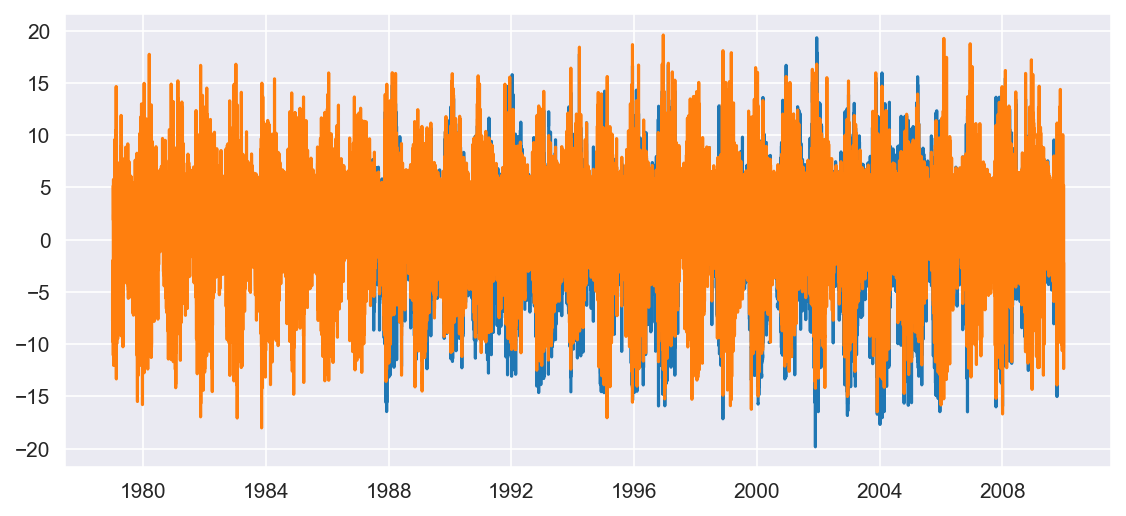

In [3]:
plt.figure(figsize=(9, 4), dpi=150)
plt.plot(t,x)
plt.plot(t,y)

### Error distribution

mean error = 0.628941 (0.617582, 0.640301), N = 146672


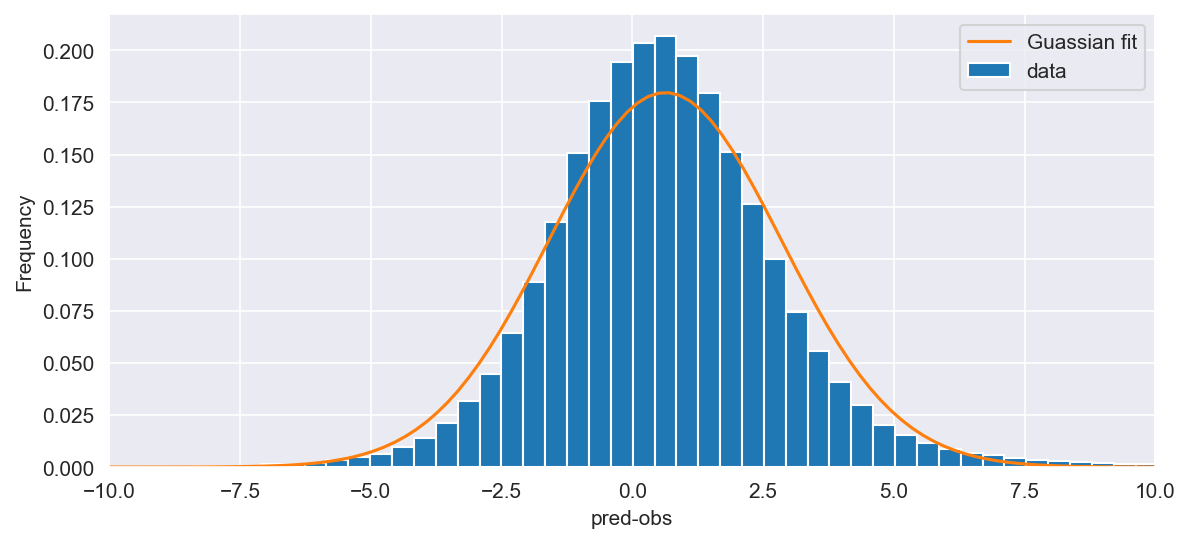

In [4]:
# Distribution of error
e = y-x
e = e[~np.isnan(e)]
e_m = np.mean(e)
e_sig = np.std(e)
es = pd.Series(e)
e_v = np.linspace(-10,10,100)
e_gauss = 1/(e_sig*np.sqrt(2*np.pi))*np.exp(-0.5*np.power((e_v-e_m)/e_sig,2))

#es.plot.kde()
plt.figure(figsize=(9, 4), dpi=150)
es.plot.hist(bins=100,density=True,label='data')
plt.plot(e_v,e_gauss,label='Guassian fit')
plt.xlim((-10, 10))
plt.xlabel('pred-obs')
plt.legend()

N = len(e)
sem = stats.sem(e)
e_bounds = stats.t.interval(0.95,N-1,loc=e_m,scale=sem)

print('mean error = {:f} ({:f}, {:f}), N = {:d}'.format(e_m,e_bounds[0],e_bounds[1],N))

### Squared Error Distribution
Sources
- https://stats.stackexchange.com/questions/78079/confidence-interval-of-rmse
- Faaber 1999, https://www.sciencedirect.com/science/article/abs/pii/S0169743999000271. Here std of RMSE = RMSE*sqrt(1/2N)

mean error = 5.322361 (5.310523, 5.334257)
mean error = 5.322361 (5.316107, 5.328616)


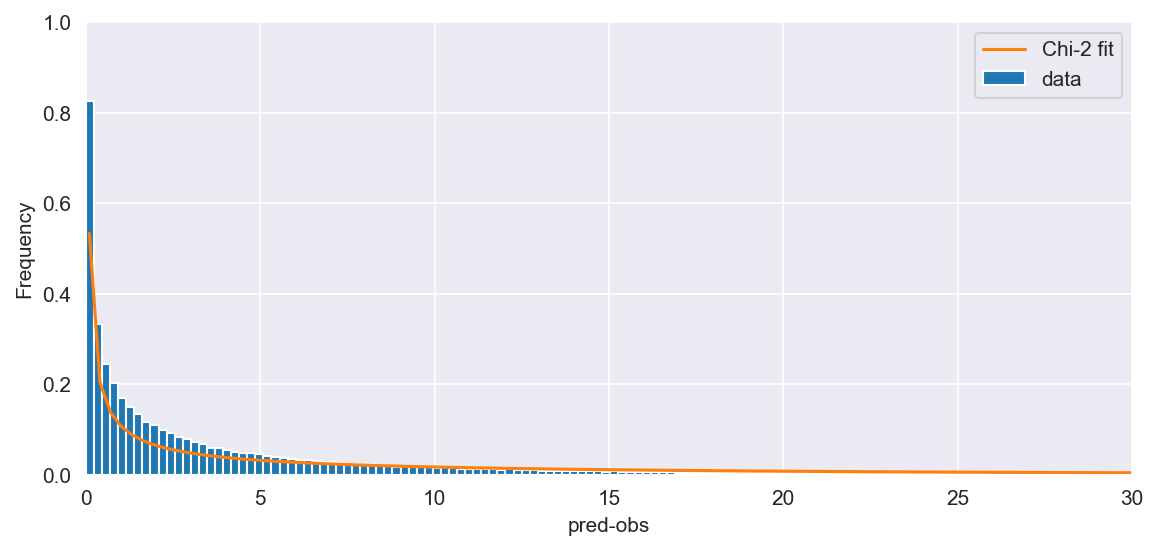

In [5]:
# Error stats
def calc_error_stats(x,y,conf=0.95,print_values=False):
    # drop NaN values in either array
    nans = np.isnan(x) | np.isnan(y)
    x = x[~nans]
    y = y[~nans]
    
    # Calculate
    e = y - x
    e_sqr = np.power(e,2)
    bias = np.mean(e)
    e_sqr_m = np.mean(e_sqr)
    rmse = np.sqrt(e_sqr_m)
    mae = np.mean(np.abs(e))
    sem = stats.sem(e_sqr)
    N = len(e)    
    rmse_bounds = np.sqrt(stats.t.interval(conf,N-1,loc=e_sqr_m,scale=sem))
    r2 = r2_score(x,y)

    if print_values:
        print('RMSE = {:f} ({:f},{:f}) \nBias = {:f} \nR2   = {:f}\n MAE = {:f}'
              .format(rmse,rmse_bounds[0],rmse_bounds[1],bias,r2,mae))

    return (rmse,rmse_bounds,bias,r2,mae)    

def rmse_conf_interval(rmse,N):
    from scipy import stats
    c1,c2 = stats.chi2.ppf([0.05,1-0.05],N)
    return ( np.sqrt(N/c2)*rmse, np.sqrt(N/c1)*rmse )

def rmse_sigma_interval(rmse,N):
    sig = rmse*np.sqrt(2/N)
    return (rmse - 2*sig, rmse + 2*sig)

# Distribution of error
N = len(x)
e = np.power(np.abs(y-x),2)
e = e[~np.isnan(e)]
e_m = np.mean(e)
e_sig = np.std(e)
es = pd.Series(e)
e_v = np.linspace(.1,30,100)
#k = 2
(shape, loc, scale) = stats.chi2.fit(e)
e_chi2 = stats.chi2.pdf(e_v, shape, loc=loc, scale=scale)

# RMSE bounds
c1,c2 = stats.chi2.ppf([0.05,1-0.05],N)
e_bounds = [np.sqrt(N/c2)*e_m,np.sqrt(N/c1)*e_m]

# Alternative
sig = np.sqrt(e_m/(2*N))
e_bounds2 = [e_m - 2*sig, e_m + 2*sig]

#e_chi2 = 0.5*np.power(e_v,k/2-1)*np.exp(-e_v/2)

#es.plot.kde()
plt.figure(figsize=(9, 4), dpi=150)
es.plot.hist(bins=3000,density=True,label='data')
plt.plot(e_v,e_chi2,label='Chi-2 fit')
plt.xlim((0, 30))
plt.xlabel('pred-obs')
plt.legend()
plt.ylim([0,1])

N = len(e)
sem = stats.sem(e)
#e_bounds = stats.chi.interval(0.95,shape,loc=loc,scale=scale)

print('mean error = {:f} ({:f}, {:f})'.format(e_m,e_bounds[0],e_bounds[1]))
print('mean error = {:f} ({:f}, {:f})'.format(e_m,e_bounds2[0],e_bounds2[1]))

### Bootstrapping

- Compare the two approaches to a bootstrapped method
- We have 272 thousand instances
- Let's take 

Results show that rmse bounds are way too small from formula

In [39]:
import random
e = np.power(y-x,2)
msk = ~np.isnan(e)
e = e[msk]
Y = y[msk]
X = x[msk]

Ns = np.linspace(10,1000,20).astype(int)
Nb = 100

sig_boot = np.zeros(len(Ns))
sig_faa = np.zeros(len(Ns))
sig_t = np.zeros(len(Ns))
for ii, nn in enumerate(Ns):
    rmse = np.zeros(Nb)
    indices = np.arange(Nb*nn)
    random.shuffle(indices)
    for i in range(Nb):
        ind = indices[(i*nn):((i+1)*nn-1)]
        xs = X[ind]
        ys = Y[ind]
        sample = e[ind]
        rmse[i] = np.sqrt(np.mean(sample))

    rmse_e = np.mean(rmse)
    sig_e = np.std(rmse)
    rb_e = [rmse_e-2*sig_e,rmse_e+2*sig_e]
    sig_boot[ii] = 100*sig_e/rmse_e
    #print('bootstrap sig = {:f} ({:4.2f} %)'.format(sig_e,100*sig_e/rmse_e))

    # Faaber 1999
    psig = np.sqrt(2/nn)
    #print('Faaber sig = {:f} ({:4.2f} %)'.format(psig*rmse_e,psig*100))
    sig_faa[ii] = psig*100
    
    (rmse3,rb_3,a,b,c) = calc_error_stats(xs,ys,conf=0.95,print_values=False)
    #print('T-Distr sig = {:f} ({:4.2f} %)'.format((rb_3[1]-rb_3[0])/4,100*(rb_3[1]-rb_3[0])/4/rmse3))
    #print('mean error = {:f} ({:f}, {:f})'.format(rmse_e,rb_e[0],rb_e[1]))
    sig_t[ii] = 100*(rb_3[1]-rb_3[0])/4/rmse3


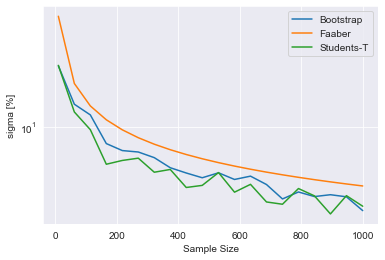

In [44]:
plt.plot(Ns,sig_boot,label='Bootstrap')
plt.plot(Ns,sig_faa,label='Faaber')
plt.plot(Ns,sig_t,label='Students-T')
plt.legend()
plt.ylabel('sigma [%]')
plt.xlabel('Sample Size')
plt.yscale('log')

In [ ]:
N = 1000
Nb = 1000
e = np.power(np.abs(y-x),2)
e = e[~np.isnan(e)]

rmse = np.zeros(Nb)
for i in range(Nb):
    indices = np.random.choice(np.arange(len(e)),N,replace=False)
    sample = e[indices]
    xs = x[indices]
    ys = y[indices]
    #sample = np.random.choice(e,size=N,replace=False)
    rmse[i] = np.mean(sample)
    
rmse_e = np.mean(rmse)
sig_e = np.std(rmse)
rb_e = [rmse_e-2*sig_e,rmse_e+2*sig_e]
print('mean error = {:f} ({:f}, {:f})'.format(rmse_e,rb_e[0],rb_e[1]))

rb_1 = rmse_conf_interval(rmse_e,N)
print('mean error = {:f} ({:f}, {:f})'.format(rmse_e,rb_1[0],rb_1[1]))

rb_2 = rmse_sigma_interval(rmse_e,N)
print('mean error = {:f} ({:f}, {:f})'.format(rmse_e,rb_2[0],rb_2[1]))

(rmse3,rb_3,a,b,c) = calc_error_stats(xs,ys,conf=0.95,print_values=False)
print('mean error = {:f} ({:f}, {:f})'.format(rmse3**2,rb_3[0]**2,rb_3[1]**2))


#plt.hist(rmse)



In [ ]:
len(x)

In [ ]:
# Error stats
def calc_error_stats(x,y,conf=0.95,print_values=False):
    # drop NaN values in either array
    nans = np.isnan(x) | np.isnan(y)
    x = x[~nans]
    y = y[~nans]
    
    # Calculate
    e = y - x
    e_sqr = np.power(e,2)
    bias = np.mean(e)
    e_sqr_m = np.mean(e_sqr)
    rmse = np.sqrt(e_sqr_m)
    mae = np.mean(np.abs(e))
    sem = stats.sem(e_sqr)
    N = len(e)    
    rmse_bounds = np.sqrt(stats.t.interval(conf,N-1,loc=e_sqr_m,scale=sem))
    #scipy.stats.chi2
    r2 = r2_score(x,y)

    if print_values:
        print('RMSE = {:f} ({:f},{:f}) \nBias = {:f} \nR2   = {:f}\n MAE = {:f}'
              .format(rmse,rmse_bounds[0],rmse_bounds[1],bias,r2,mae))

    return (rmse,rmse_bounds,bias,r2,mae)


(rmse,rmse_bounds,bias,r2,mae) = calc_error_stats(x,y,0.95,True)

In [ ]:
nans = np.isnan(x) | np.isnan(y)
x = x[~nans]
y = y[~nans]
e = np.abs(y-x)
e2 = np.power(y-x,2)

plt.hist(e2,100)